In [1]:
# %matplotlib notebook # use this to show interactive figures
%matplotlib inline
from datetime import datetime
from geopy import distance
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
raw_train_data = pd.read_csv('./input/train.csv', parse_dates=['Date'])
raw_test_data = pd.read_csv('./input/test.csv', parse_dates=['Date'])
spray_data = pd.read_csv('./input/spray.csv', parse_dates=['Date'])
weather_data = pd.read_csv('./input/weather.csv')

In [3]:
print(spray_data.shape, raw_train_data.shape)

(14835, 4) (10506, 12)


In [4]:
def select_date(df, start, end):
    """Return rows which are in the closed range between start and end."""
    return df[(start <= df.Date) & (df.Date <= end)]

### sprayした日とtrainデータの日付

- スプレーは、2011年に2日、2013年に8日の、計10日間だけ
- 2011年のスプレー日前後には観測日は無いので、2013年だけ考える
- 2013年のスプレーされた日前後の観測日もあんまりない

In [5]:
#select_date(spray_data, datetime(2011,5,1), datetime(2011,11,1)).groupby('Date').count()
spray_data.groupby('Date').count()

,Time,Latitude,Longitude
Date,,,
2011-08-29,95,95,95
2011-09-07,1530,2114,2114
2013-07-17,2202,2202,2202
2013-07-25,1607,1607,1607
2013-08-08,1195,1195,1195
2013-08-15,2668,2668,2668
2013-08-16,141,141,141
2013-08-22,1587,1587,1587
2013-08-29,2302,2302,2302


In [6]:
print("data around 2011/08/29: %s\ndata around 2011/09/07: %s" %
      (raw_train_data.pipe(select_date, datetime(2011,8,29),datetime(2011,8,31)).shape, 
       raw_train_data.pipe(select_date, datetime(2011,9,7),datetime(2011,9,10)).shape))

data around 2011/08/29: (0, 12)
data around 2011/09/07: (0, 12)


In [7]:
start_date = datetime(2013,7,17)
end_date = datetime(2013,9,10)
train_in_range = (raw_train_data
    .pipe(select_date, start=start_date, end=end_date)
    .groupby('Date')
    .count()
)
print(train_in_range.Latitude.sum())
train_in_range

1312


,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2013-07-19,182,182,182,182,182,182,182,182,182,182,182
2013-07-25,153,153,153,153,153,153,153,153,153,153,153
2013-08-01,186,186,186,186,186,186,186,186,186,186,186
2013-08-08,181,181,181,181,181,181,181,181,181,181,181
2013-08-15,157,157,157,157,157,157,157,157,157,157,157
2013-08-22,167,167,167,167,167,167,167,167,167,167,167
2013-08-29,143,143,143,143,143,143,143,143,143,143,143
2013-09-06,143,143,143,143,143,143,143,143,143,143,143


#### スプレーした日と観測日 (2013)
- だいたいスプレーと同日か２日後までには観測日がある

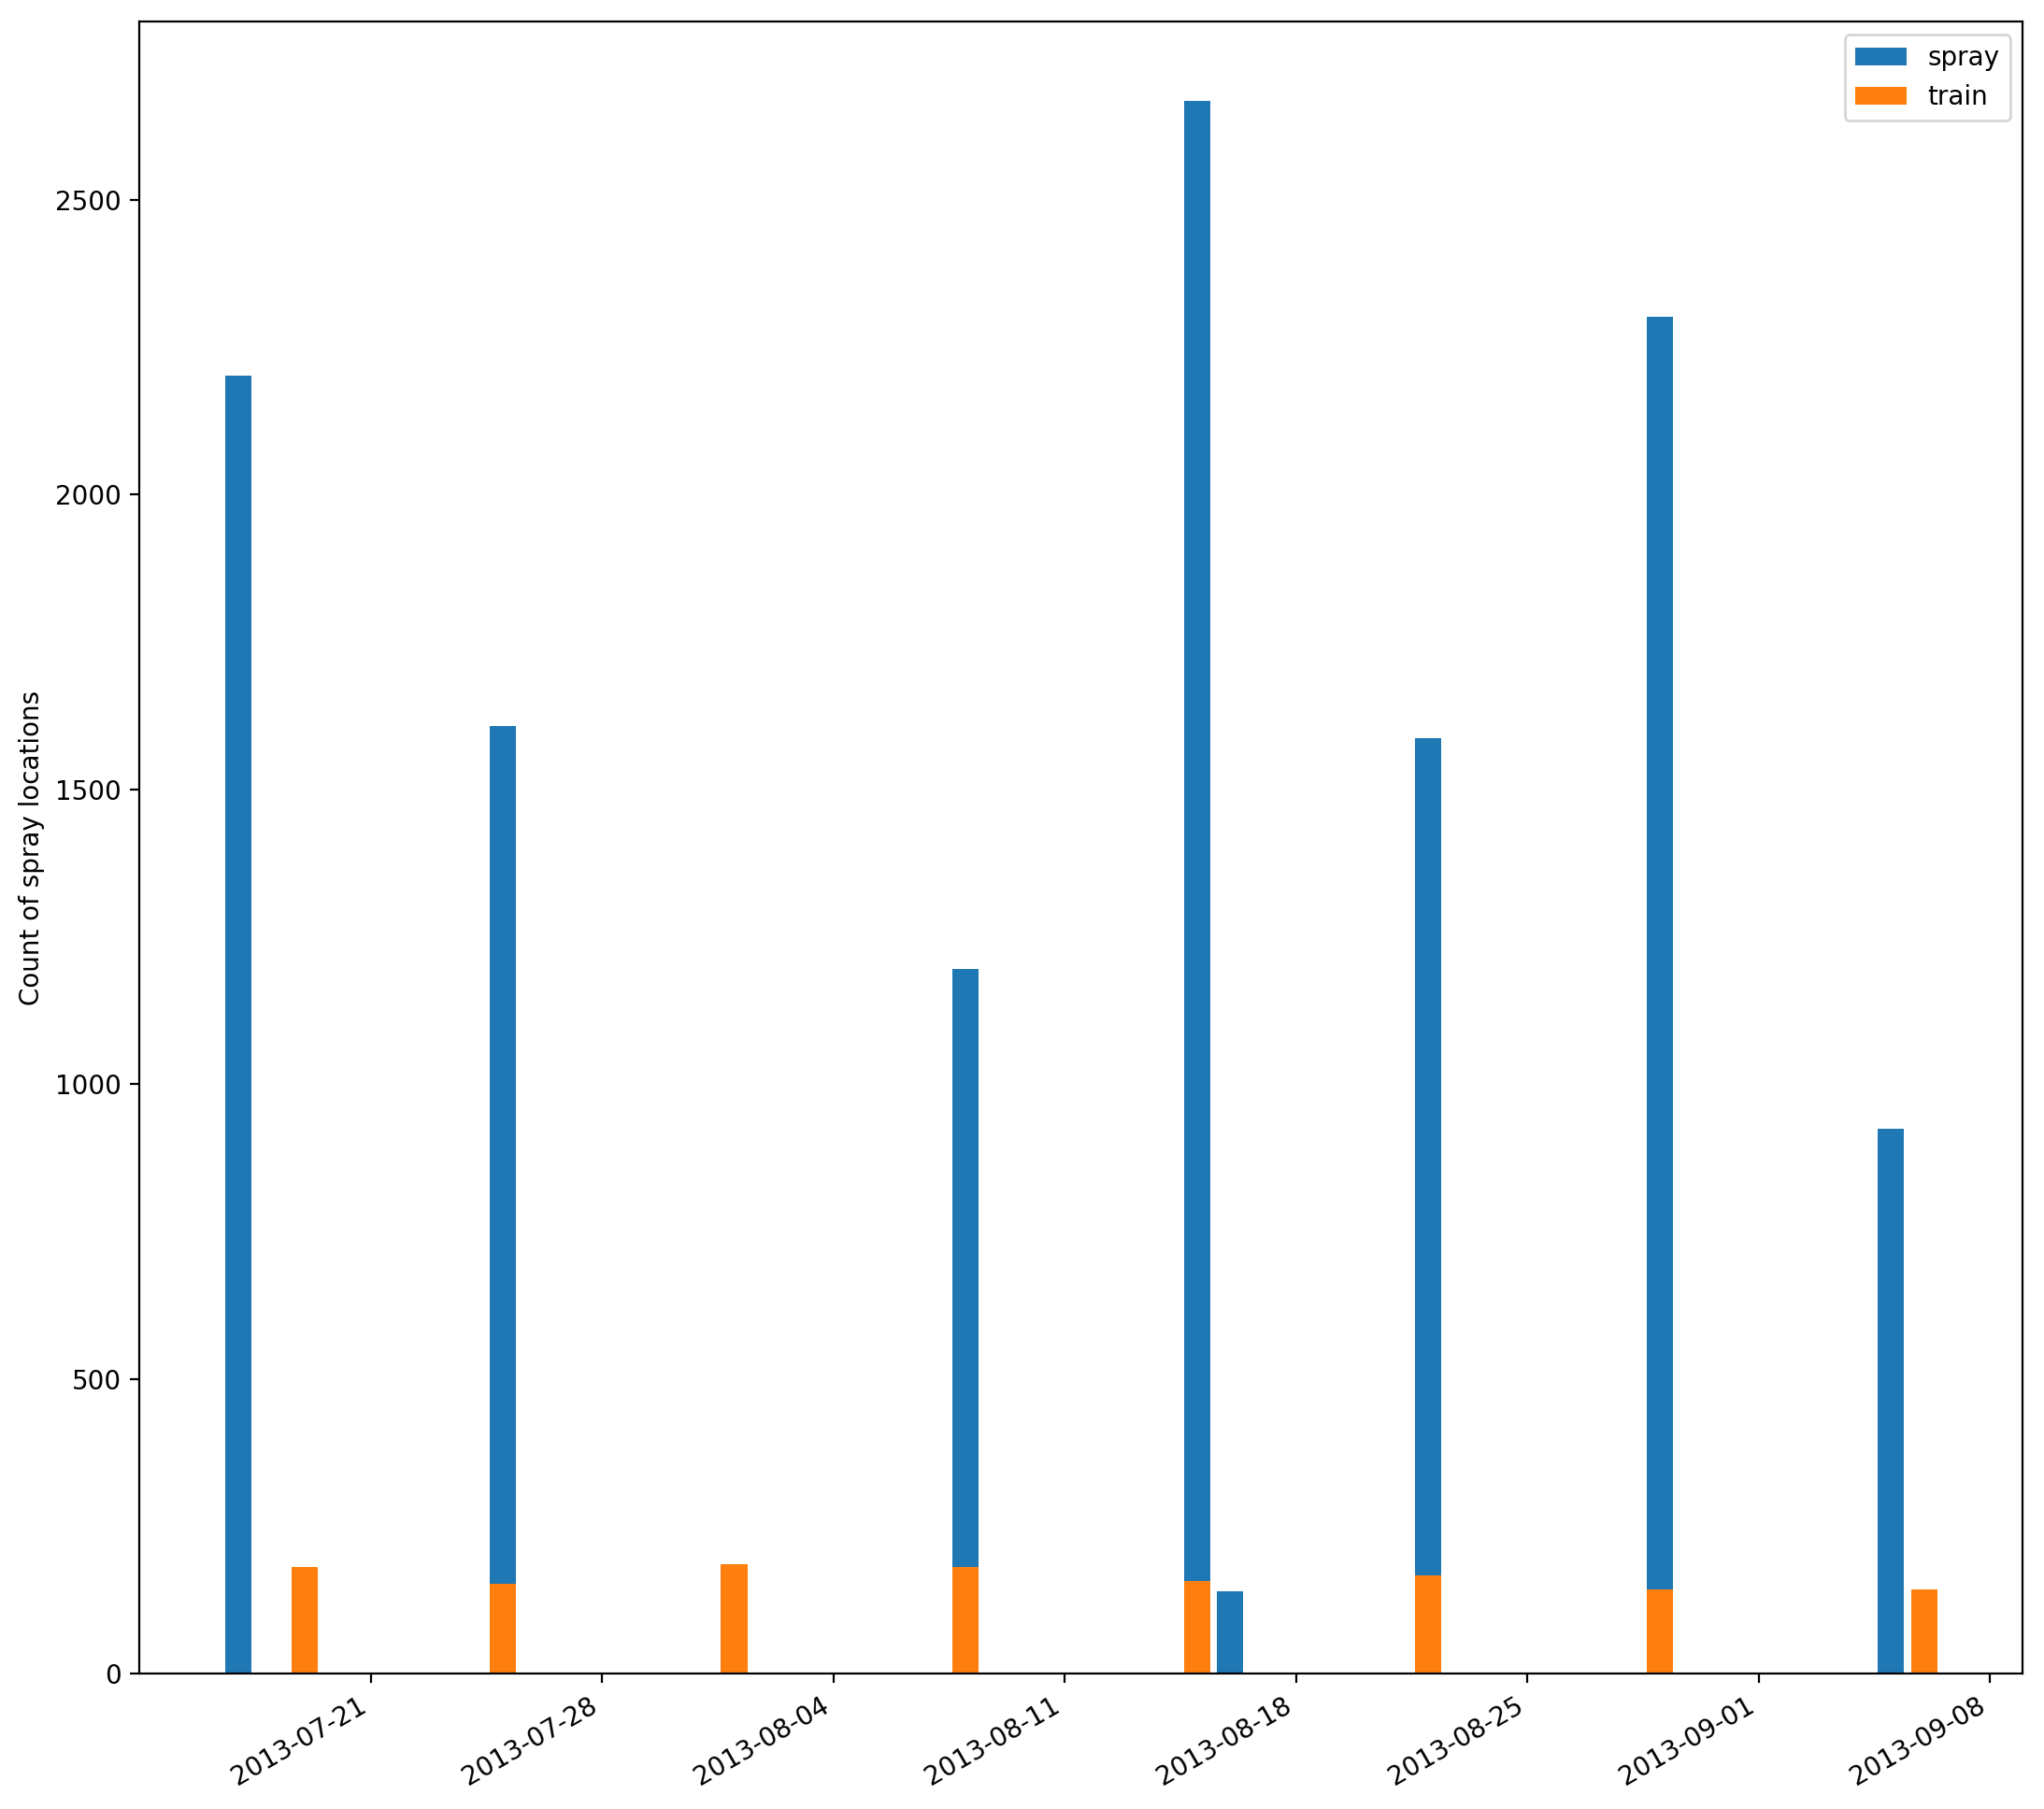

In [8]:
fig = plt.figure(figsize=(13, 13), dpi=200)
ax = fig.add_subplot(111)
d1 = select_date(spray_data, start_date, end_date).groupby('Date').count().reset_index()
d2 = select_date(raw_train_data, start_date, end_date).groupby('Date').count().reset_index()

ax.bar(x=d1.Date.get_values(), height=d1.Latitude, label='spray')
ax.bar(x=d2.Date.get_values(), height=d2.Latitude, label='train')
ax.xaxis_date()
ax.legend()
ax.set_ylabel('Count of spray locations')
fig.autofmt_xdate()

In [9]:
def dist_in_km(a, b):
    return distance.distance((a.Latitude, a.Longitude), (b.Latitude, b.Longitude)).km

def find_min_dist(row, spray, offset_days, fill_na_by=np.nan):
    return spray.pipe(
        select_date, row.Date-offset_days, row.Date
    ).apply(
        dist_in_km, args=(row,), axis=1
    ).pipe(
        # at this point, df should not be empty, just in case
        lambda df: fill_na_by if df.empty else df.min()
    )

In [10]:
def select_sprayed(df, spray, offset_days):
    spray_date_index = df.Date != df.Date # all False
    for spray_date in spray.Date.unique():
        # Select dates between unique spray date and the day offset_days after
        spray_date_index |= (spray_date <= df.Date) & (df.Date <= offset_days.apply(spray_date))
    
    return df[spray_date_index]

def parallel_apply(df, func, args, n=cpu_count()+1):
    p = Pool(n)
    splitted = [{'df': spl_df, 'args': args} for spl_df in np.array_split(df, n*20)]
    result = p.map(func, splitted)
    p.close()
    p.join()
    return pd.concat(result)

def create_min_dist_series(args_dict):
    result_series = args_dict['df'].apply(find_min_dist, args=args_dict['args'], axis=1)
    # if no results, return empty series
    if result_series.shape[0] == 0:
        return pd.Series()
    
    return result_series

def min_dist(df, spray, days=2):
    """Returns a Series of minimum distances to the spray location within days for each row in df

    Args:
        df (pandas.DataFrame): needs following columns ['Date', 'Latitude', 'Longitude']
        days (int): 
    Returns:
        pandas.Series: Series of minimum distances to the spray location within `days` for each row in df
    """

    offset_days = pd.tseries.offsets.Day(days=days)
    
    return df.pipe(
        select_sprayed, spray, offset_days
    ).pipe(
        parallel_apply, create_min_dist_series, args=(spray, offset_days)
    )

In [11]:
# this may take several minutes
train_with_spray = raw_train_data.assign(
    ClosestSprayKmIn2Days=lambda df: min_dist(df, spray_data)
)

test_with_spray = raw_test_data.assign(
    ClosestSprayKmIn2Days=lambda df: min_dist(df, spray_data)
)

In [12]:
test_with_spray.ClosestSprayKmIn2Days.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ClosestSprayKmIn2Days, dtype: float64

In [13]:
train_with_spray.ClosestSprayKmIn2Days.describe()

count    944.000000
mean      11.591091
std        8.648979
min        0.003234
25%        4.701004
50%        9.319977
75%       16.346929
max       43.076493
Name: ClosestSprayKmIn2Days, dtype: float64

In [14]:
ranged_train_with_spray = train_with_spray.pipe(select_date, start_date, end_date)[['Date', 'NumMosquitos', 'WnvPresent', 'ClosestSprayKmIn2Days']].dropna()

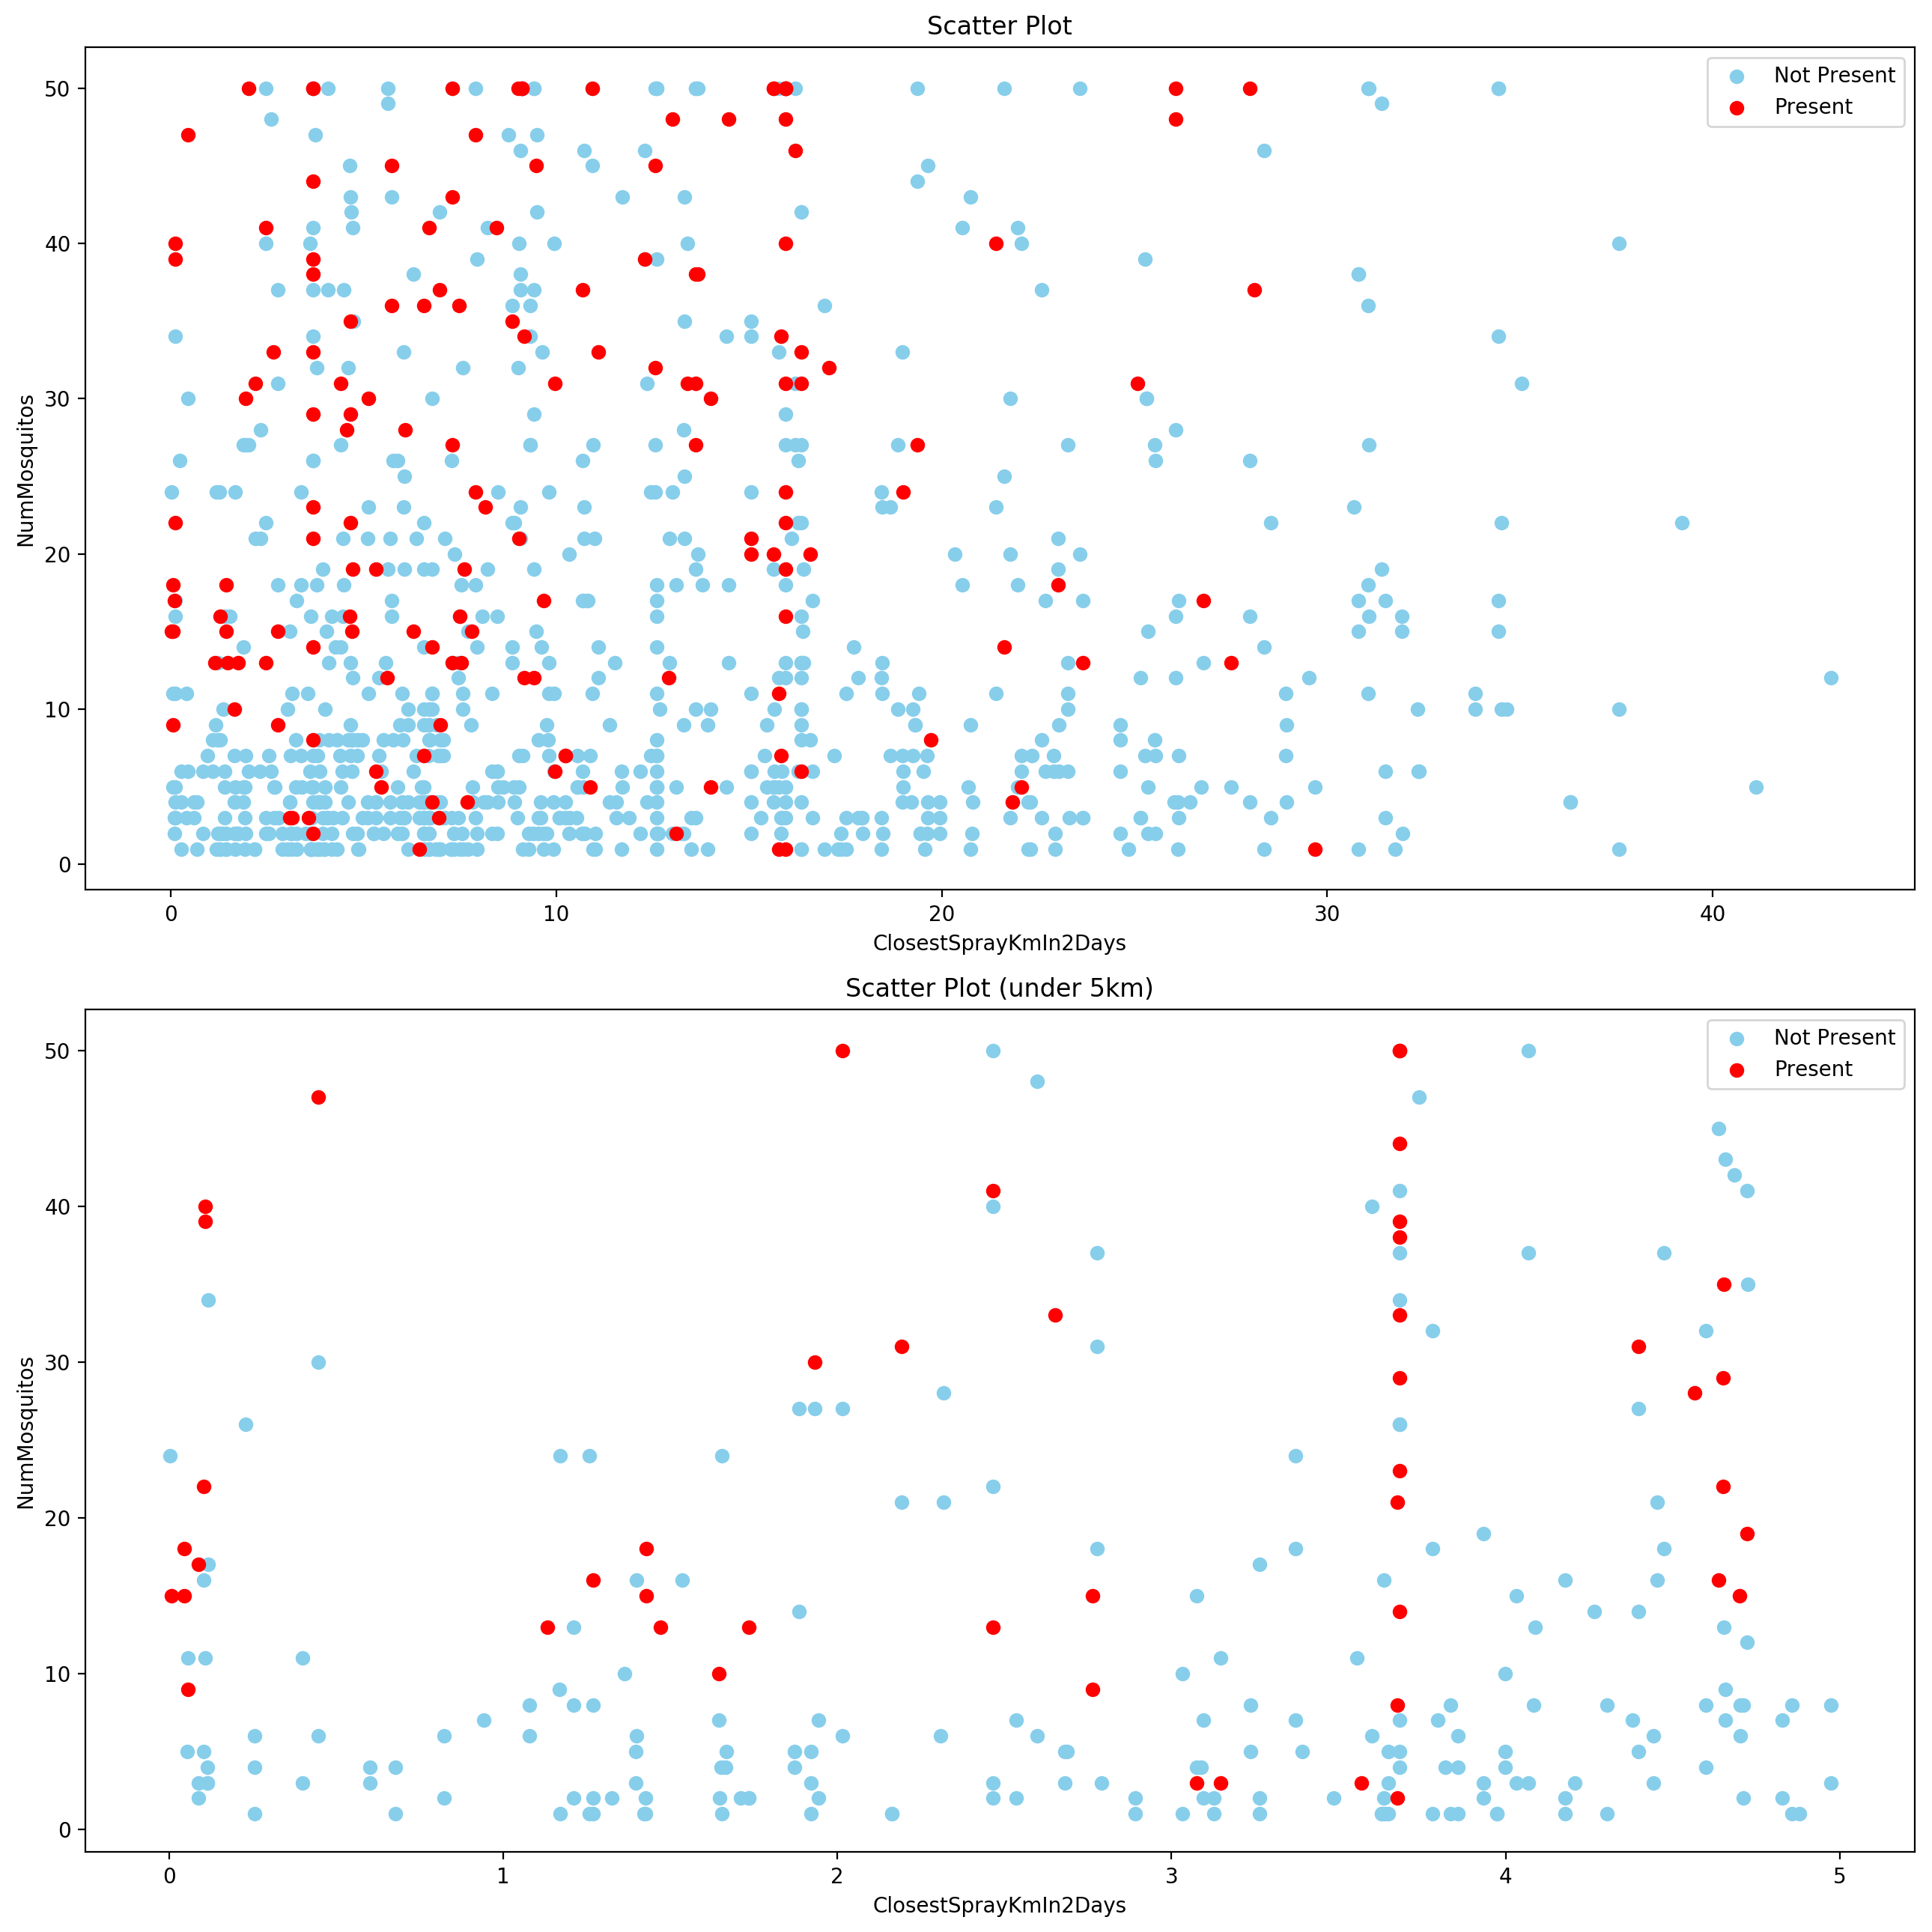

In [15]:
def scatter_plot(ax, positive_data, negative_data):
    ax.scatter(negative_data['ClosestSprayKmIn2Days'], negative_data['NumMosquitos'], c='skyblue', label='Not Present')
    ax.scatter(positive_data['ClosestSprayKmIn2Days'], positive_data['NumMosquitos'], c='red', label='Present')
    ax.legend()
    ax.set_xlabel("ClosestSprayKmIn2Days")
    ax.set_ylabel("NumMosquitos")

negative_data = ranged_train_with_spray[ranged_train_with_spray['WnvPresent'] == 0]
positive_data = ranged_train_with_spray[ranged_train_with_spray['WnvPresent'] == 1]
fig_scatter = plt.figure(figsize=(13, 13), dpi=200)
ax1 = fig_scatter.add_subplot(211)
ax2 = fig_scatter.add_subplot(212)
scatter_plot(ax1, positive_data, negative_data)
scatter_plot(ax2, positive_data[positive_data['ClosestSprayKmIn2Days'] < 5], negative_data[negative_data['ClosestSprayKmIn2Days'] < 5])
ax1.set_title('Scatter Plot')
ax2.set_title('Scatter Plot (under 5km)')
plt.tight_layout()
plt.show()